In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# ================== Core Python ==================
import os
import shutil

# ================== Image and Data Handling ==================
from PIL import Image

# ================== PyTorch ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image

# ================== Visualization ==================
import matplotlib.pyplot as plt

# ================== Utilities ==================
from tqdm import tqdm, trange
from tqdm.auto import tqdm as auto_tqdm

# ================== Data Science ==================
import numpy as np
import pandas as pd

# ================== Sklearn ==================
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [ ]:
# Paths
original_train = '/content/drive/MyDrive/Alzheimer_Dataset/train'
original_test = '/content/drive/MyDrive/Alzheimer_Dataset/test'
processed_train = '/content/processed/train'
processed_test = '/content/processed/test'

# Transform to resize + normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def preprocess_and_save(input_path, output_path):
    dataset = ImageFolder(input_path)
    os.makedirs(output_path, exist_ok=True)

    for class_name in dataset.classes:
        os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

    for img_path, label in tqdm(dataset.samples, desc=f"Preprocessing {input_path}"):
        image = Image.open(img_path).convert('RGB')
        tensor_img = transform(image)
        class_name = dataset.classes[label]
        save_path = os.path.join(output_path, class_name, os.path.basename(img_path))
        save_image(tensor_img, save_path)

# Preprocess train and test
preprocess_and_save(original_train, processed_train)
preprocess_and_save(original_test, processed_test)


Preprocessing /content/drive/MyDrive/Alzheimer_Dataset/train: 100%|██████████| 10240/10240 [48:12<00:00,  3.54it/s]
Preprocessing /content/drive/MyDrive/Alzheimer_Dataset/test: 100%|██████████| 1279/1279 [07:18<00:00,  2.91it/s]


In [ ]:
train_dataset = ImageFolder(processed_train, transform=transforms.ToTensor())
test_dataset = ImageFolder(processed_test, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [ ]:
class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes):
        super(AlzheimerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerCNN(num_classes=len(class_names)).to(device)


In [ ]:
print(device)

cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 25
best_model_path = '/content/best_alz_model.pth'
patience = 4
best_val_loss = float('inf')
early_stop_counter = 0


In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loader_tqdm.set_postfix({'Loss': loss.item(), 'Acc': f'{100 * correct / total:.2f}%'})

    model.eval()
    val_loss, correct, total = 0, 0, 0
    val_loader_tqdm = tqdm(test_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            val_loader_tqdm.set_postfix({'Loss': loss.item(), 'Acc': f'{100 * correct / total:.2f}%'})

    train_acc = 100 * correct / len(train_dataset)
    val_acc = 100 * correct / len(test_dataset)
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    print(f"\nSummary Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("✔️ Saved best model.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping.")
            break


Epoch [1/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 40.61it/s, Loss=0.775, Acc=66.85%]



Summary Epoch 1: Train Loss=0.7134, Val Loss=0.7400
✔️ Saved best model.


Epoch [2/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 43.02it/s, Loss=0.369, Acc=72.01%]



Summary Epoch 2: Train Loss=0.4106, Val Loss=0.6051
✔️ Saved best model.


Epoch [3/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 43.03it/s, Loss=0.21, Acc=76.00%]



Summary Epoch 3: Train Loss=0.2902, Val Loss=0.5018
✔️ Saved best model.


Epoch [4/25] Validation: 100%|██████████| 40/40 [00:01<00:00, 27.98it/s, Loss=0.794, Acc=81.39%]



Summary Epoch 4: Train Loss=0.1943, Val Loss=0.4130
✔️ Saved best model.


Epoch [5/25] Validation: 100%|██████████| 40/40 [00:01<00:00, 32.77it/s, Loss=0.695, Acc=83.35%]



Summary Epoch 5: Train Loss=0.1451, Val Loss=0.3583
✔️ Saved best model.


Epoch [6/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 41.71it/s, Loss=0.117, Acc=92.57%]



Summary Epoch 6: Train Loss=0.1020, Val Loss=0.2019
✔️ Saved best model.


Epoch [7/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 43.88it/s, Loss=0.116, Acc=95.93%]



Summary Epoch 7: Train Loss=0.0917, Val Loss=0.1329
✔️ Saved best model.


Epoch [8/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 43.51it/s, Loss=0.488, Acc=91.87%]



Summary Epoch 8: Train Loss=0.0666, Val Loss=0.2217


Epoch [9/25] Validation: 100%|██████████| 40/40 [00:01<00:00, 28.22it/s, Loss=0.195, Acc=96.33%]



Summary Epoch 9: Train Loss=0.0503, Val Loss=0.1136
✔️ Saved best model.


Epoch [10/25] Validation: 100%|██████████| 40/40 [00:01<00:00, 30.69it/s, Loss=0.188, Acc=96.01%]



Summary Epoch 10: Train Loss=0.0480, Val Loss=0.1193


Epoch [11/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 40.15it/s, Loss=0.209, Acc=92.89%]



Summary Epoch 11: Train Loss=0.0467, Val Loss=0.1798


Epoch [12/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 42.05it/s, Loss=0.184, Acc=93.98%]



Summary Epoch 12: Train Loss=0.0457, Val Loss=0.1553


Epoch [13/25] Validation: 100%|██████████| 40/40 [00:00<00:00, 42.62it/s, Loss=0.536, Acc=88.82%]


Summary Epoch 13: Train Loss=0.0434, Val Loss=0.2974
⏹️ Early stopping.


                      precision    recall  f1-score   support

     Mild Impairment       0.96      0.99      0.97       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.96      0.98      0.97       640
Very Mild Impairment       0.97      0.93      0.95       448

            accuracy                           0.96      1279
           macro avg       0.97      0.95      0.96      1279
        weighted avg       0.96      0.96      0.96      1279



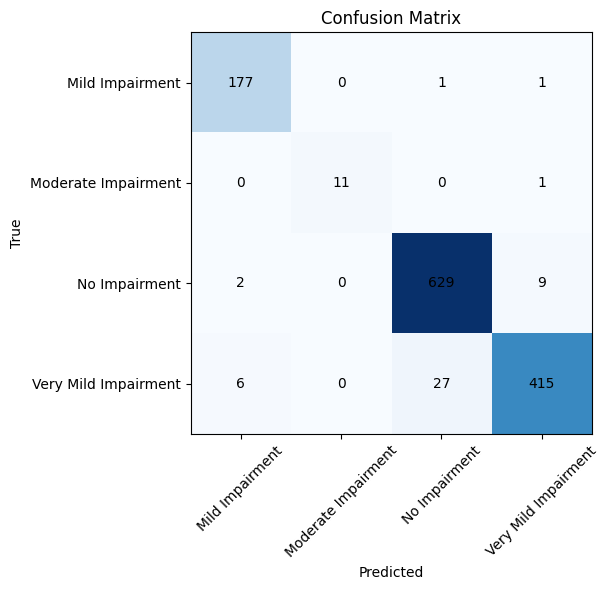

In [ ]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [19]:
cnn_accs = [0.96]
cnn_f1s = [0.96]


In [ ]:
torch.save(model.state_dict(), 'alz_model_weights.pth')


In [ ]:
# Folder you want to zip
folder_to_zip = "/content/processed"

# Output zip file name
zip_output = "/content/processed_images.zip"

# Create zip archive
shutil.make_archive(base_name=zip_output.replace(".zip", ""), format='zip', root_dir=folder_to_zip)




'/content/processed_images.zip'

In [4]:
# Load processed images
data_transform = transforms.ToTensor()

train_dataset = ImageFolder(r"C:\Users\samyo\Downloads\processed_images\train", transform=data_transform)
test_dataset = ImageFolder(r"C:\Users\samyo\Downloads\processed_images\test", transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

def get_numpy_data(loader):
    for imgs, labels in loader:
        X = imgs.view(imgs.size(0), -1).numpy()
        y = labels.numpy()
        return X, y

X_train, y_train = get_numpy_data(train_loader)
X_test, y_test = get_numpy_data(test_loader)

print("✅ Loaded preprocessed image data.")


✅ Loaded preprocessed image data.


In [ ]:
print("🔁 Training SGDClassifier (Logistic Regression Style)")

sgd = SGDClassifier(loss='log_loss')  # 'log_loss' ≈ logistic regression
epochs = 10
batch_size = 2048
n_train = X_train.shape[0]

train_accuracies, val_accuracies = [], []

for epoch in trange(epochs, desc="Epochs"):
    indices = np.random.permutation(n_train)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    for i in range(0, n_train, batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]

        if epoch == 0 and i == 0:
            sgd.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        else:
            sgd.partial_fit(X_batch, y_batch)

    y_pred_epoch = sgd.predict(X_test)
    acc = accuracy_score(y_test, y_pred_epoch)
    f1 = f1_score(y_test, y_pred_epoch, average='macro')

    train_accuracies.append(acc)
    val_accuracies.append(f1)

# Final evaluation
y_pred_final = sgd.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_final)
log_f1 = f1_score(y_test, y_pred_final, average='macro')

print(f"\n✅ Logistic Regression (SGDClassifier) Accuracy: {log_acc:.4f}")
print(f"✅ Logistic Regression (SGDClassifier) F1 Score: {log_f1:.4f}")


🔁 Training SGDClassifier (Logistic Regression Style)


Epochs: 100%|██████████| 10/10 [01:28<00:00,  8.90s/it]


✅ Logistic Regression (SGDClassifier) Accuracy: 0.8788
✅ Logistic Regression (SGDClassifier) F1 Score: 0.8617


In [ ]:
rf_epochs = 1  # training happens once
rf_accs, rf_f1s = [], []

print("🌲 Training Random Forest...")

for epoch in trange(rf_epochs, desc="Epochs"):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    rf_accs.append(acc)
    rf_f1s.append(f1)

print(f"\n✅ Final Random Forest Accuracy: {rf_accs[-1]:.4f}")
print(f"✅ Final Random Forest F1 Score: {rf_f1s[-1]:.4f}")


🌲 Training Random Forest...


Epochs: 100%|██████████| 1/1 [02:41<00:00, 161.66s/it]


✅ Final Random Forest Accuracy: 0.9109
✅ Final Random Forest F1 Score: 0.8768


In [ ]:
pca_epochs = 5
pca_log_accs, pca_log_f1s = [], []

print("🔄 Training PCA + Logistic Regression...")

for epoch in trange(pca_epochs, desc="Epochs"):
    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_pca, y_train)
    
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    pca_log_accs.append(acc)
    pca_log_f1s.append(f1)

print(f"\n✅ Final PCA + Logistic Accuracy: {pca_log_accs[-1]:.4f}")
print(f"✅ Final PCA + Logistic F1 Score: {pca_log_f1s[-1]:.4f}")


🔄 Training PCA + Logistic Regression...


Epochs: 100%|██████████| 5/5 [03:09<00:00, 37.86s/it]


✅ Final PCA + Logistic Accuracy: 0.6169
✅ Final PCA + Logistic F1 Score: 0.6855


In [ ]:
ensemble_epochs = 1
ens_accs, ens_f1s = [], []

print("⚖️ Training Ensemble (Voting Classifier)...")

for epoch in trange(ensemble_epochs, desc="Epochs"):
    ensemble = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=100))
        ],
        voting='soft'
    )
    ensemble.fit(X_train, y_train)
    
    y_pred = ensemble.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    ens_accs.append(acc)
    ens_f1s.append(f1)

print(f"\n✅ Final Ensemble Accuracy: {ens_accs[-1]:.4f}")
print(f"✅ Final Ensemble F1 Score: {ens_f1s[-1]:.4f}")


⚖️ Training Ensemble (Voting Classifier)...


Epochs: 100%|██████████| 1/1 [08:57<00:00, 537.48s/it]


✅ Final Ensemble Accuracy: 0.9625
✅ Final Ensemble F1 Score: 0.9716


C:\Users\samyo\AppData\Local\Temp\ipykernel_6900\3519588885.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\samyo\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


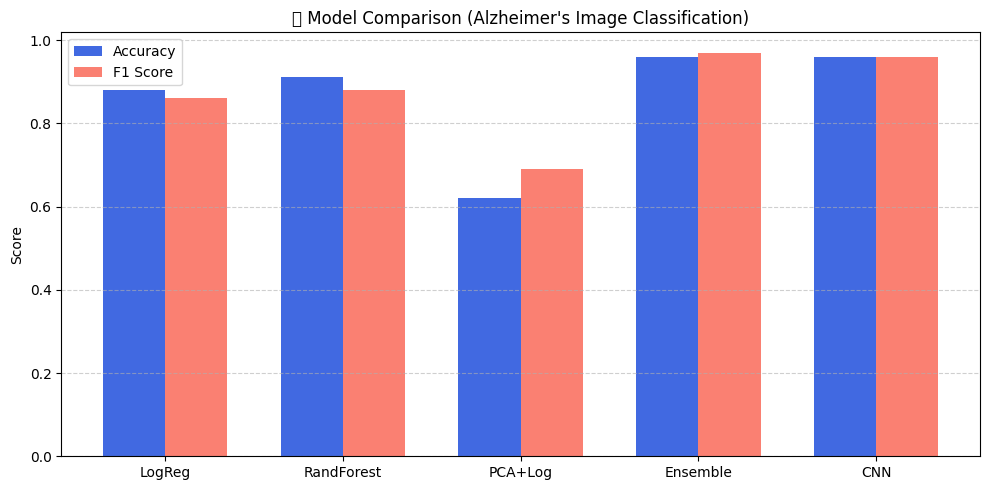

In [ ]:
log_acc = 0.88; log_f1 = 0.86
rf_acc = 0.91; rf_f1 = 0.88
pca_log_acc = 0.62; pca_log_f1 = 0.69
ens_acc = 0.96; ens_f1 = 0.97
cnn_acc = 0.96; cnn_f1 = 0.96

# Now use them directly, not as lists
models = ['LogReg', 'RandForest', 'PCA+Log', 'Ensemble', 'CNN']
accs = [log_acc, rf_acc, pca_log_acc, ens_acc, cnn_acc]
f1s = [log_f1, rf_f1, pca_log_f1, ens_f1, cnn_f1]

x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, accs, bar_width, label='Accuracy', color='royalblue')
plt.bar(x + bar_width/2, f1s, bar_width, label='F1 Score', color='salmon')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("📊 Model Comparison (Alzheimer's Image Classification)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
